# Machine Learning Essentials SS25 - Exercise Sheet 4

## Instructions
- `TODO`'s indicate where you need to complete the implementations.
- You may use external resources, but <b>write your own solutions</b>.
- Provide concise, but comprehensible comments to explain what your code does.
- Code that's unnecessarily extensive and/or not well commented will not be scored.

## Exercise 2

### Task 1

(a) derive d/dx tanh(x) = 

- d/dx tan (x) = d/dx (sin(x) / cos(x)) 

 -   = (cos(x) * cos(x) - sin(x) * sin(x)) / cos^2(x) 

 - = 1 / cos^2(x)  , because cos^2 x - sin^2x = 1

 - = sec ^2(x)
    
 -   = 1 - tan^2(x) 






- (b) Gradient of BCE loss w.r.t. output layer's preactivation: δ(2) = ŷ - y


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

### Task 2

In [2]:
# TODO: Define the needed helper functions
def tanh_prime(x_activated):
    return 1 - x_activated ** 2

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def binary_cross_entropy(y_hat, y):
    """
    Computes the BCE loss over samples.
    """
    # Hint: Add a small epsilon to y_hat to prevent numerical issues w/ log(0) issues (that's common practice in these cases)
    epsilon = 1e-15
    y_hat = np.clip(y_hat, epsilon, 1 - epsilon)  # no log 0
    return -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

In [3]:
# MLP Class
class MLP:
    def __init__(self, layer_dims, initialization_scale=1):
        """
        Initializes the multi-layer perceptron.
        Args:
            layer_dims (list of int): List containing the number of neurons in each layer.
                                      [d0, d1, d2] = [2, 10, 1] for the exercise.
                                      d0: input dimension
                                      d1: hidden layer dimension
                                      d2: output dimension
            initialization_scale (float): Scaling factor for weight initialization (i.e. standard deviation of the normal distribution)
        """
        self.parameters = {}
        self.num_layers = len(layer_dims) 

        # Weights are initialized by drawing from a standard normal distribution, biases are initialized as zero.
        # For more complex networks, one usually uses techniques like Xavier or He initialization. Play around with the initialization_scale parameter to see how it affects the training!
        # Layer 0 -> Layer 1
        self.parameters['W0'] = np.random.randn(layer_dims[1], layer_dims[0]) * initialization_scale 
        self.parameters['b0'] = np.zeros((layer_dims[1], 1))
        # Layer 1 -> Layer 2
        self.parameters['W1'] = np.random.randn(layer_dims[2], layer_dims[1]) * initialization_scale
        self.parameters['b1'] = np.zeros((layer_dims[2], 1))
        
        self.cache = {} # For storing intermediate values (needed for backprop)

    def forward(self, X_batch):
        """
        Forward pass through the network. Store intermediate values in self.cache for backward pass.
        """
        # TODO: Implement the forward pass & store the needed values in self.cache
        z0 = X_batch
        
        # Hidden layer (layer 1)
        z1_tilde = self.parameters['W0'] @ z0 + self.parameters['b0']  # Preactivation
        z1 = np.tanh(z1_tilde)  # Activation
        
        # Output layer (layer 2)
        z2_tilde = self.parameters['W1'] @ z1 + self.parameters['b1']  # Preactivation
        y_hat = sigmoid(z2_tilde)  # Sigmoid activation for binary classification
        
        # Store values needed for backpropagation
        self.cache = {
            'z0': z0,           # Input
            'z1_tilde': z1_tilde,  # Hidden preactivation
            'z1': z1,           # Hidden activation
            'z2_tilde': z2_tilde,  # Output preactivation
            'y_hat': y_hat      # Final output
        }
        
        return y_hat

    def backward(self, Y_batch):
        """
        Performs the backward pass (= backpropagation) to compute gradients of the loss with respect to the parameters.
        Gradients are stored in the grads dictionary (see update_params method).
        """
        # TODO: Implement the backward pass
        # Get cached values
        z0 = self.cache['z0']
        z1_tilde = self.cache['z1_tilde']
        z1 = self.cache['z1']
        y_hat = self.cache['y_hat']
        
        m = Y_batch.shape[1]  # Number of samples in batch
        
        # Step 1: Compute δ(2) = ŷ - y (gradient w.r.t. output preactivation)
        delta2 = y_hat - Y_batch
        
        # Step 2: Compute gradients for output layer parameters
        dW1 = (1/m) * (delta2 @ z1.T)  # Average over batch
        db1 = (1/m) * np.sum(delta2, axis=1, keepdims=True)
        
        # Step 3: Compute δ(1) using backpropagation recursion
        delta1 = (self.parameters['W1'].T @ delta2) * tanh_prime(z1)
        
        # Step 4: Compute gradients for hidden layer parameters
        dW0 = (1/m) * (delta1 @ z0.T)  # Average over batch
        db0 = (1/m) * np.sum(delta1, axis=1, keepdims=True)
        
        # Store gradients in dictionary
        grads = {
            'dW0': dW0,
            'db0': db0,
            'dW1': dW1,
            'db1': db1
        }
        
        return grads

    def update_params(self, grads, learning_rate):
        """
        Updates the parameters using gradient descent.
        Args:
            grads (dict): Dictionary of gradients.
            learning_rate (float): The learning rate.
        """
        self.parameters['W0'] -= learning_rate * grads['dW0']
        self.parameters['b0'] -= learning_rate * grads['db0']
        self.parameters['W1'] -= learning_rate * grads['dW1']
        self.parameters['b1'] -= learning_rate * grads['db1']

### Task 3
TODO: Explain why using vectorized operations is generally preferred in ML.

Vectorized operations are preferred in ML because:

1. **Performance**: Vectorized operations use optimized linear algebra libraries (BLAS, LAPACK)
   that are implemented in C/Fortran and can leverage hardware acceleration (SIMD instructions,
   multi-threading, GPU parallelization).

2. **Memory efficiency**: Vectorized operations minimize memory allocations and improve cache
   locality by processing data in contiguous memory blocks.

3. **Readability**: Matrix/vector notation is more concise and closer to mathematical formulation,
   making code easier to understand and debug.

4. **Numerical stability**: Optimized libraries often include better handling of edge cases
   and numerical precision issues.

For example, computing gradients with explicit loops over neurons/features would be much slower
than using matrix multiplication, especially for large networks and datasets.


### Task 4

In [4]:
#Data loading and preprocessing (predefined)
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# NOTE: Different libraries/languages use different conventions for the shape of the data matrix X, which comes from the way they store data in memory:
#   - In ML textbooks/mathematical notation, X is often (n_features, n_samples), because each sample is a (n_features, 1) column vector and we stack them "horizontally".
#   - This is consistent with some languages (e.g. Julia, Matlab), which store data in column-major order.
#   - However, most ML code (e.g. NumPy, sklearn, Pytorch) is optimized for row-major order, so you will in code most often see data matrices of shape (n_samples, n_features).
#     (The reason for that is that most of these libraries run C/C++/CUDA code under the hood, which is optimized for row-major order)
# --> Juggling the shapes of arrays to be correctly aligned with the used model implementation / convention is a day-to-day task in practical ML and the cause of many bugs, so always double-check the expected format.

X_train = X_train.T  # Shape: (2, 350)
X_test = X_test.T    # Shape: (2, 150)
y_train = y_train.reshape(1, -1)  # Shape: (1, 350)
y_test = y_test.reshape(1, -1)    # Shape: (1, 150)


# TODO: The MLP class you're using expects its inputs in a specific shape, make sure your X and y match that convention.
print(f"Shape of X_train: {X_train.shape}") 
print(f"Shape of y_train: {y_train.shape}") 
print(f"Shape of X_test: {X_test.shape}") 
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (2, 350)
Shape of y_train: (1, 350)
Shape of X_test: (2, 150)
Shape of y_test: (1, 150)


Epoch 100/1000 - Training Loss: 0.2006
Epoch 200/1000 - Training Loss: 0.1478
Epoch 300/1000 - Training Loss: 0.1188
Epoch 400/1000 - Training Loss: 0.0990
Epoch 500/1000 - Training Loss: 0.0851
Epoch 600/1000 - Training Loss: 0.0755
Epoch 700/1000 - Training Loss: 0.0689
Epoch 800/1000 - Training Loss: 0.0641
Epoch 900/1000 - Training Loss: 0.0606
Epoch 1000/1000 - Training Loss: 0.0579


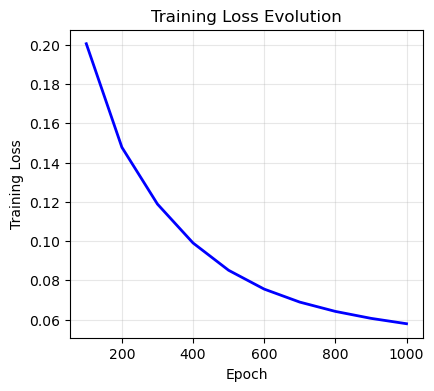

In [5]:
# Training
layer_dimensions = [X_train.shape[0], 10, 1] # d0, d1, d2 as given in the exercise
mlp = MLP(layer_dimensions) # Initialize the MLP

# Hyperparameters
learning_rate = 0.5   # Good balance between speed and stability
num_epochs = 1000     # Sufficient for convergence
print_loss = 100      # Print every 100 epochs
train_losses = []


for epoch in range(1,num_epochs+1):
    # Forward pass
    y_hat_train = mlp.forward(X_train)
    # Compute loss
    train_loss = binary_cross_entropy(y_hat_train, y_train)
    # Backward pass = backprop
    grads = mlp.backward(y_train)
   # Update parameters by gradient descent
    mlp.update_params(grads, learning_rate)
    
    if epoch % print_loss == 0 or epoch == num_epochs:
       train_losses.append(train_loss)
       print(f"Epoch {epoch}/{num_epochs} - Training Loss: {train_loss:.4f}")

# Plotting the training loss
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(print_loss, num_epochs + 1, print_loss), train_losses, 'b-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Evolution')
plt.grid(True, alpha=0.3)



Test Loss: 0.0598
Test Accuracy: 99.33%


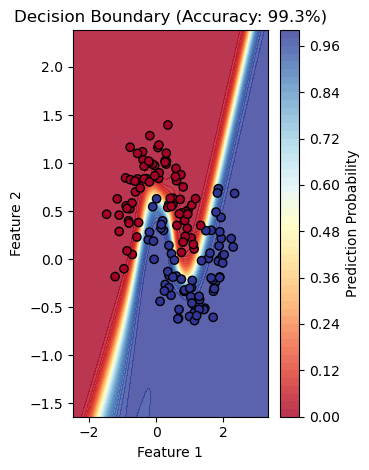


ANALYSIS:
• The network successfully learned to classify the Two Moons dataset
• Final test accuracy: 99.33%
• The decision boundary successfully separates the two moon-shaped clusters
• The nonlinear activation functions (tanh in hidden layer) enable the network
  to learn the complex, nonlinear decision boundary required for this dataset
• The smooth decision boundary shows the network has generalized well


In [6]:
# Evaluation 
# TODO: Compute the accuracy on the test set and plot the decision boundary over the test set, comment on the performance

y_hat_test = mlp.forward(X_test)
test_loss = binary_cross_entropy(y_hat_test, y_test)

# Compute accuracy
predictions = (y_hat_test > 0.5).astype(int)
accuracy = np.mean(predictions == y_test) * 100

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")

# Plot decision boundary
def plot_decision_boundary(mlp, X, y, title="Decision Boundary"):
    """Plot the decision boundary of the trained MLP"""
    # Create a mesh of points
    h = 0.02
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Make predictions on the mesh
    mesh_points = np.c_[xx.ravel(), yy.ravel()].T
    Z = mlp.forward(mesh_points)
    Z = Z.reshape(xx.shape)
    
    # Create the plot
    plt.contourf(xx, yy, Z, levels=50, alpha=0.8, cmap=plt.cm.RdYlBu)
    plt.colorbar(label='Prediction Probability')
    
    # Plot the data points
    scatter = plt.scatter(X[0, :], X[1, :], c=y.ravel(), cmap=plt.cm.RdYlBu, edgecolors='black')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)

plt.subplot(1, 2, 2)
plot_decision_boundary(mlp, X_test, y_test, f"Decision Boundary (Accuracy: {accuracy:.1f}%)")

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("ANALYSIS:")
print("="*60)
print(f"• The network successfully learned to classify the Two Moons dataset")
print(f"• Final test accuracy: {accuracy:.2f}%")
print(f"• The decision boundary successfully separates the two moon-shaped clusters")
print(f"• The nonlinear activation functions (tanh in hidden layer) enable the network")
print(f"  to learn the complex, nonlinear decision boundary required for this dataset")
print(f"• The smooth decision boundary shows the network has generalized well")
print("="*60)
